# Projeto Final

# Modelo de Previsão de Pagamentos em Atraso

#### Importação das bibliotecas necessárias

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import mlflow
from mlflow.models import infer_signature
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import seaborn as sns
import shap

#### Load dataset

In [2]:
#load dataset
df=pd.read_csv(r'C:\Users\ricky\Desktop\PGDCBI\Projeto Final\WA_Fn-UseC_-Accounts-Receivable.csv', encoding = 'latin')
df.set_index('invoiceNumber', inplace=True)

In [3]:
df

,countryCode,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
invoiceNumber,,,,,,,,,,,
611365,391,0379-NEVHP,4/6/2013,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
7900770,406,8976-AMJEO,3/3/2012,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
9231909,391,2820-XGXSB,1/26/2012,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
9888306,406,9322-YCTQO,4/6/2012,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
15752855,818,6627-ELFBK,11/26/2012,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4
...,...,...,...,...,...,...,...,...,...,...,...
9982796720,391,6708-DPYTF,8/2/2012,10/18/2013,11/17/2013,79.61,No,12/1/2013,Electronic,44,14
9983237240,391,9841-XLGBV,1/3/2013,9/19/2012,10/19/2012,38.25,No,10/13/2012,Paper,24,0
9986249860,770,7856-ODQFO,8/5/2012,7/2/2012,8/1/2012,67.59,No,7/27/2012,Paper,25,0


#### Feature Enginnering

In [4]:
#Substituir 'CountryCode' pelo seu respetivo nome do país 
df['countryName'] = df['countryCode'].replace({ 391:'Germany',406:'Australia',818:'California, US',897:'Kansas, US',770:'Georgia, US' })
df.drop('countryCode',axis = 1,inplace = True)

# Converter variável 'CountryName' em dummies 
country_dummies = (pd.get_dummies(df['countryName'], prefix='Country', drop_first=True)).astype('object') 
country_dummies = country_dummies.applymap(lambda x: '1' if x else '0')
country_dummies = country_dummies.astype('object')

df = pd.concat([df, country_dummies], axis=1)

In [5]:
#Converter variáveis data que estão como object em datatime em datatime
date_variables = ['PaperlessDate', 'InvoiceDate', 'DueDate', 'SettledDate']

for date in date_variables:
    df[date] = pd.to_datetime(df[date])

In [6]:
# Convert variáveis categóricas em dummies
df['PaperlessBill_dummy'] = (pd.get_dummies(df['PaperlessBill'], drop_first=True)).astype('int')
df['PaperlessBill_dummy'] = df['PaperlessBill_dummy'].astype('object')

df['Disputed'] = (df['Disputed'].replace({'Yes': 1, 'No': 0})).astype('object')

# Drop variáveis que já não são necessárias
df.drop(['PaperlessBill', 'countryName'], axis=1, inplace=True)

print(df.dtypes)
df

customerID                        object
PaperlessDate             datetime64[ns]
InvoiceDate               datetime64[ns]
DueDate                   datetime64[ns]
InvoiceAmount                    float64
Disputed                          object
SettledDate               datetime64[ns]
DaysToSettle                       int64
DaysLate                           int64
Country_California, US            object
Country_Georgia, US               object
Country_Germany                   object
Country_Kansas, US                object
PaperlessBill_dummy               object
dtype: object


,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,DaysToSettle,DaysLate,"Country_California, US","Country_Georgia, US",Country_Germany,"Country_Kansas, US",PaperlessBill_dummy
invoiceNumber,,,,,,,,,,,,,,
611365,0379-NEVHP,2013-04-06,2013-01-02,2013-02-01,55.94,0,2013-01-15,13,0,0,0,1,0,1
7900770,8976-AMJEO,2012-03-03,2013-01-26,2013-02-25,61.74,1,2013-03-03,36,6,0,0,0,0,0
9231909,2820-XGXSB,2012-01-26,2013-07-03,2013-08-02,65.88,0,2013-07-08,5,0,0,0,1,0,0
9888306,9322-YCTQO,2012-04-06,2013-02-10,2013-03-12,105.92,0,2013-03-17,35,5,0,0,0,0,0
15752855,6627-ELFBK,2012-11-26,2012-10-25,2012-11-24,72.27,1,2012-11-28,34,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982796720,6708-DPYTF,2012-08-02,2013-10-18,2013-11-17,79.61,0,2013-12-01,44,14,0,0,1,0,0
9983237240,9841-XLGBV,2013-01-03,2012-09-19,2012-10-19,38.25,0,2012-10-13,24,0,0,0,1,0,1
9986249860,7856-ODQFO,2012-08-05,2012-07-02,2012-08-01,67.59,0,2012-07-27,25,0,0,1,0,0,1


In [7]:
# Calcular a diferença entre 'SettledDate' e 'DueDate'
df['IsLate'] = (df['SettledDate'] - df['DueDate']).dt.days

# Criar uma nova variável binária indicando se a fatura está atrasada
df['IsLate'] = (df['DaysLate'] > 0).astype(int)

# Exibir as primeiras linhas do DataFrame com a nova variável
print(df[['SettledDate', 'DueDate', 'DaysLate', 'IsLate']].head())

              SettledDate    DueDate  DaysLate  IsLate
invoiceNumber                                         
611365         2013-01-15 2013-02-01         0       0
7900770        2013-03-03 2013-02-25         6       1
9231909        2013-07-08 2013-08-02         0       0
9888306        2013-03-17 2013-03-12         5       1
15752855       2012-11-28 2012-11-24         4       1


In [8]:
#check min and max da 'invoice date'
invoice_date_min = df['InvoiceDate'].min()
invoice_date_max = df['InvoiceDate'].max()

print(f'min: {invoice_date_min}')
print(f'max: {invoice_date_max}')

min: 2012-01-03 00:00:00
max: 2013-12-02 00:00:00


## Data Understanding

In [9]:
# Resumo Estatístico das variáveis numéricas
# Selecionar apenas as variáveis numéricas
df_numeric = df.select_dtypes(include=['int', 'float']).columns.tolist()
df[df_numeric].describe()

,InvoiceAmount,DaysToSettle,DaysLate,IsLate
count,2466.000000,2466.00000,2466.000000,2466.000000
mean,59.895856,26.44485,3.442417,0.355637
std,20.435838,12.33493,6.290607,0.478803
min,5.260000,0.00000,0.000000,0.000000
25%,46.400000,18.00000,0.000000,0.000000
50%,60.560000,26.00000,0.000000,0.000000
75%,73.765000,35.00000,5.000000,1.000000
max,128.280000,75.00000,45.000000,1.000000


In [10]:
#check missing values
missing_values = df.isna().sum()

duplicates = df.duplicated()
duplicates

print(f'Existem missing values?')
print(missing_values)
print('-------------------------')
print(f'Existem valores duplicados?')
print(df[duplicates])

Existem missing values?
customerID                0
PaperlessDate             0
InvoiceDate               0
DueDate                   0
InvoiceAmount             0
Disputed                  0
SettledDate               0
DaysToSettle              0
DaysLate                  0
Country_California, US    0
Country_Georgia, US       0
Country_Germany           0
Country_Kansas, US        0
PaperlessBill_dummy       0
IsLate                    0
dtype: int64
-------------------------
Existem valores duplicados?
Empty DataFrame
Columns: [customerID, PaperlessDate, InvoiceDate, DueDate, InvoiceAmount, Disputed, SettledDate, DaysToSettle, DaysLate, Country_California, US, Country_Georgia, US, Country_Germany, Country_Kansas, US, PaperlessBill_dummy, IsLate]
Index: []


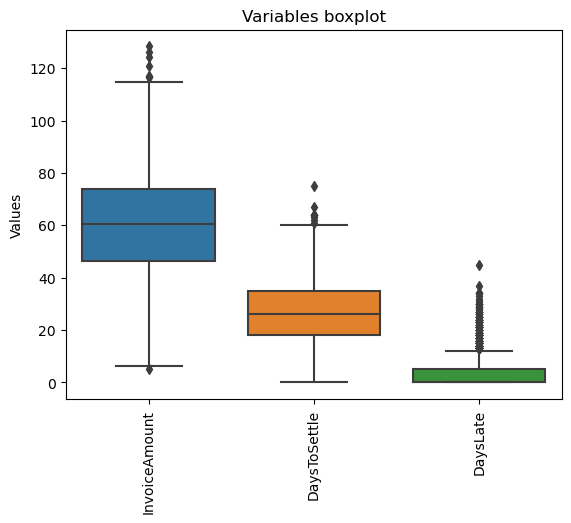

In [11]:
df_boxplot=df[['InvoiceAmount', 'DaysToSettle', 'DaysLate']].copy()

#Confirmar se existem outliers
sns.boxplot(data=df_boxplot)

#Boxplot plot
plt.xticks(ticks=np.arange(len(df_boxplot.columns)), rotation=90)
plt.ylabel('Values')
plt.title('Variables boxplot')
plt.show()

In [12]:
#criar função para checar e remover outliers
def check_outliers(df):
    for col in df_boxplot:
    # calculate IQR for column Height
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # identificar outliers
        threshold = 1.5
        outliers = df[(df[col] < Q1 - threshold * IQR) | (df[col] > Q3 + threshold * IQR)]

    print(f'Existem {outliers.shape[0]} outliers no dataset')

check_outliers(df)

# drop linhas que contêm outliers
#df_after_remove_outliers = df.drop(outliers.index)


Existem 259 outliers no dataset


#### Existem outliers no dataset, contudo, devido ao contexto que estamos a analisar, pode ser importante manter os mesmos.
Por este motivo, vamos avançar com o modelo com os outliers e avaliar os resultados com e sem os outliers para perceber se a sua presença afeta as previsões.

### Estatísticas Descritivas para as variáveis numéricas

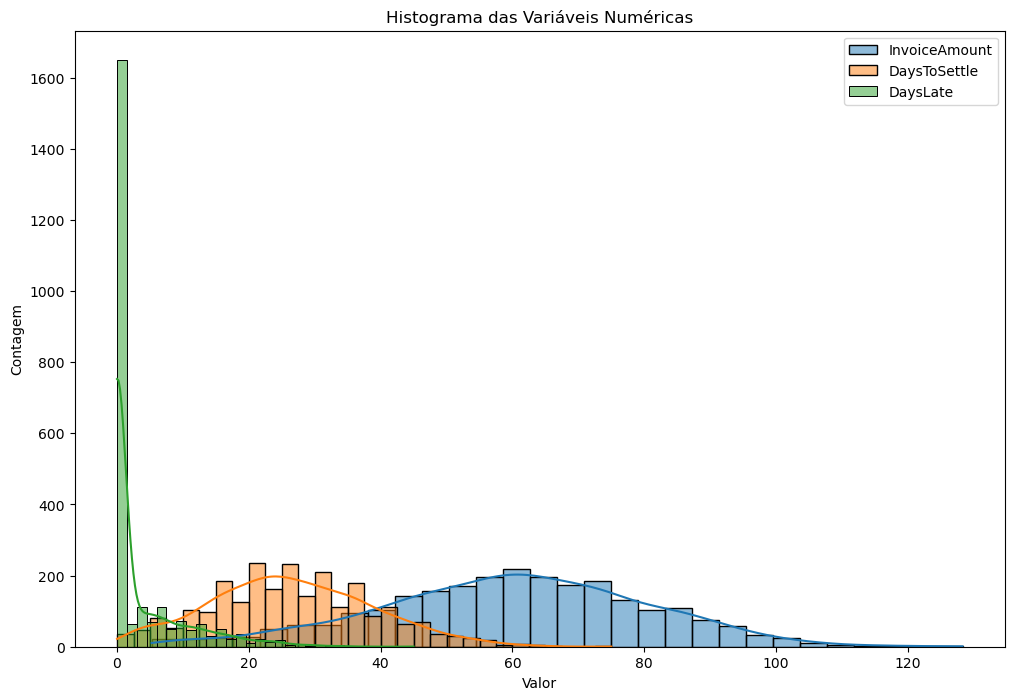

In [13]:
#Histogramas das variáveis numéricas para entender sua distribuição

df_numeric=df[['InvoiceAmount', 'DaysToSettle', 'DaysLate']].copy()
df_numeric

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Iterar sobre cada variável numérica e fazer o histograma
for col in df_numeric.columns:
    sns.histplot(df[col], kde=True, bins=30, alpha=0.5, label=col)

# Adicionar título e rótulos dos eixos
plt.title('Histograma das Variáveis Numéricas')
plt.xlabel('Valor')
plt.ylabel('Contagem')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

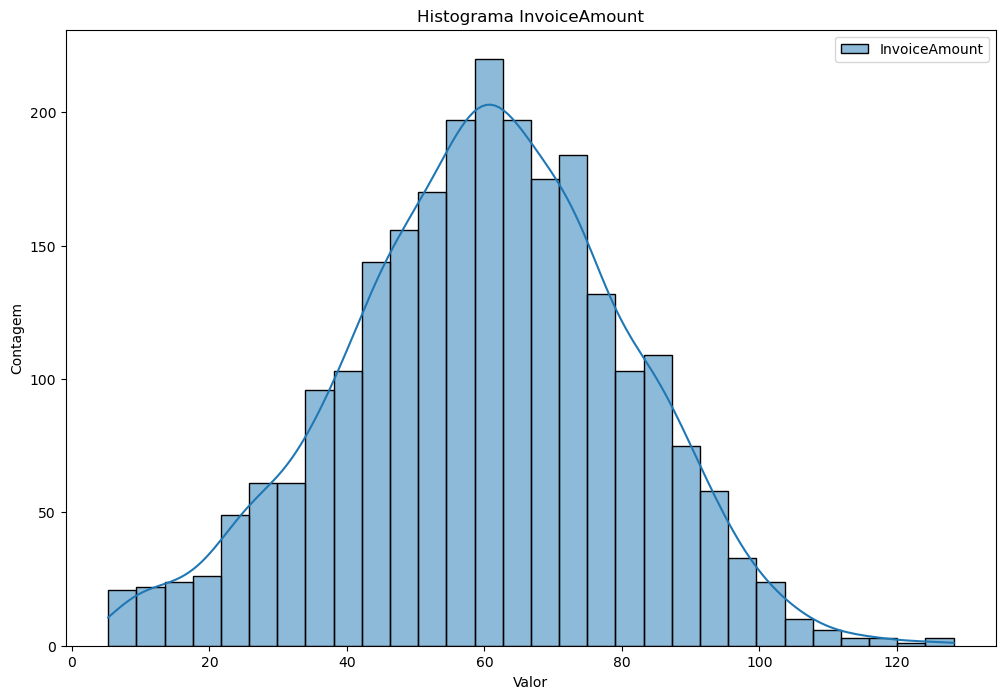

In [14]:
#Histogramas individual das variáveis numéricas para entender sua distribuição

df_invoice=df[['InvoiceAmount']].copy()
df_invoice

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Iterar sobre cada variável numérica e fazer o histograma
for col in df_invoice.columns:
    sns.histplot(df[col], kde=True, bins=30, alpha=0.5, label=col)

# Adicionar título e rótulos dos eixos
plt.title('Histograma InvoiceAmount')
plt.xlabel('Valor')
plt.ylabel('Contagem')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

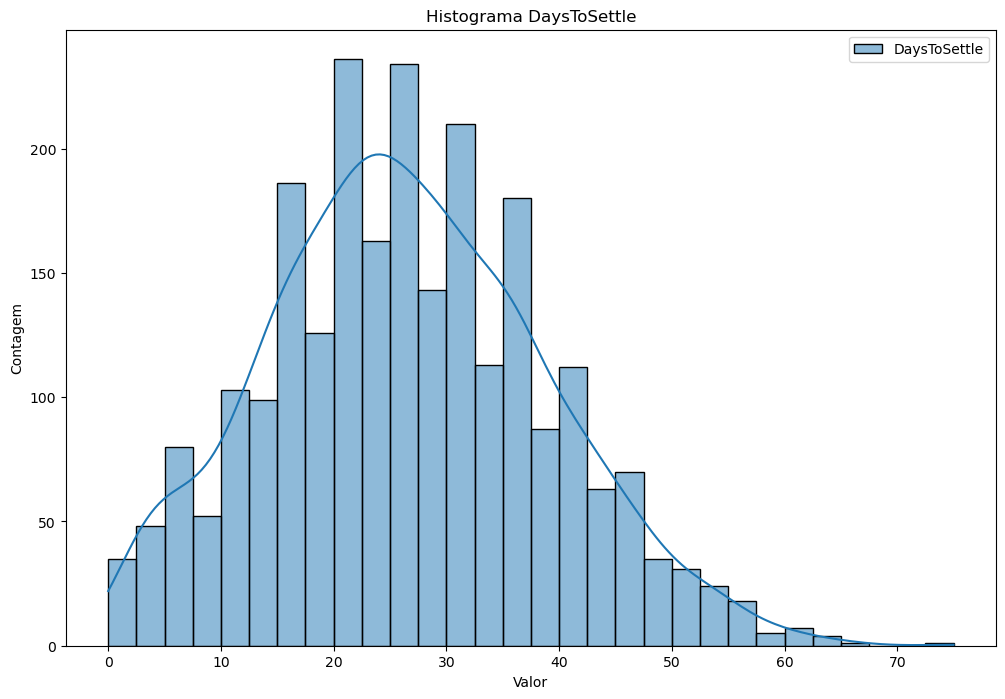

In [15]:
#Histogramas individual das variáveis numéricas para entender sua distribuição

df_daysToSettle=df[['DaysToSettle']].copy()
df_daysToSettle

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Iterar sobre cada variável numérica e fazer o histograma
for col in df_daysToSettle.columns:
    sns.histplot(df[col], kde=True, bins=30, alpha=0.5, label=col)

# Adicionar título e rótulos dos eixos
plt.title('Histograma DaysToSettle')
plt.xlabel('Valor')
plt.ylabel('Contagem')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

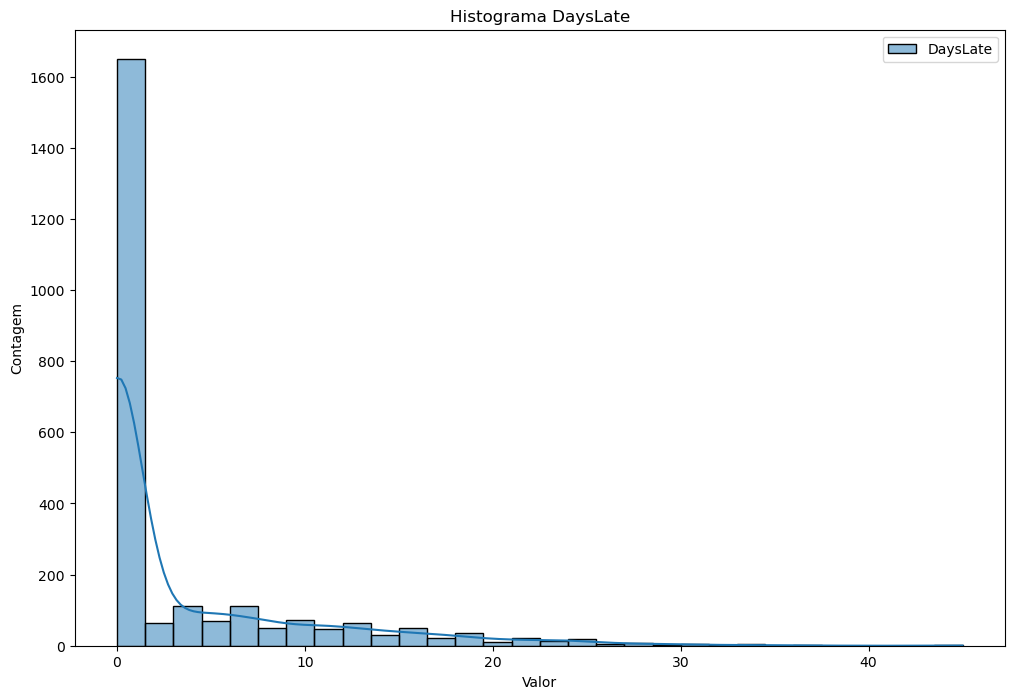

In [16]:
#Histogramas individual das variáveis numéricas para entender sua distribuição

df_daysLate=df[['DaysLate']].copy()
df_daysLate

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Iterar sobre cada variável numérica e fazer o histograma
for col in df_daysLate.columns:
    sns.histplot(df[col], kde=True, bins=30, alpha=0.5, label=col)

# Adicionar título e rótulos dos eixos
plt.title('Histograma DaysLate')
plt.xlabel('Valor')
plt.ylabel('Contagem')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

In [17]:
# Calcular a simetria (skewness) e a curtose (kurtosis) das variáveis numéricas
skewness = df_numeric.skew()
kurtosis = df_numeric.kurtosis()

# Criar um DataFrame com as métricas
metrics_df = pd.DataFrame({'Simetria (Skewness)': skewness, 'Curtose (Kurtosis)': kurtosis})

# Mostrar as métricas
print(metrics_df)

               Simetria (Skewness)  Curtose (Kurtosis)
InvoiceAmount            -0.123416           -0.095203
DaysToSettle              0.241493           -0.200746
DaysLate                  2.158827            4.697808


### Estatísticas Descritivas para as variáveis categóricas

In [18]:
# Selecionar variáveis categóricas
df_categorical = df.select_dtypes(include='object').drop('customerID', axis=1)

In [19]:
# Calcular as frequências das categorias para cada variável categórica
for column in df_categorical.columns:
    freq_table = df[column].value_counts()
    print("Frequências para", column, ":\n", freq_table)

Frequências para Disputed :
 Disputed
0    1905
1     561
Name: count, dtype: int64
Frequências para Country_California, US :
 Country_California, US
0    2079
1     387
Name: count, dtype: int64
Frequências para Country_Georgia, US :
 Country_Georgia, US
0    1960
1     506
Name: count, dtype: int64
Frequências para Country_Germany :
 Country_Germany
0    1850
1     616
Name: count, dtype: int64
Frequências para Country_Kansas, US :
 Country_Kansas, US
0    2070
1     396
Name: count, dtype: int64
Frequências para PaperlessBill_dummy :
 PaperlessBill_dummy
1    1263
0    1203
Name: count, dtype: int64


### Analisar alguma relação dos clientes que estão atrasados com outras variáveis

In [20]:
#create new variavel to tag customers that are late in their payments
df['IsLate'] = (df['DaysLate'] > 0).astype(int) 
df

,customerID,PaperlessDate,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,DaysToSettle,DaysLate,"Country_California, US","Country_Georgia, US",Country_Germany,"Country_Kansas, US",PaperlessBill_dummy,IsLate
invoiceNumber,,,,,,,,,,,,,,,
611365,0379-NEVHP,2013-04-06,2013-01-02,2013-02-01,55.94,0,2013-01-15,13,0,0,0,1,0,1,0
7900770,8976-AMJEO,2012-03-03,2013-01-26,2013-02-25,61.74,1,2013-03-03,36,6,0,0,0,0,0,1
9231909,2820-XGXSB,2012-01-26,2013-07-03,2013-08-02,65.88,0,2013-07-08,5,0,0,0,1,0,0,0
9888306,9322-YCTQO,2012-04-06,2013-02-10,2013-03-12,105.92,0,2013-03-17,35,5,0,0,0,0,0,1
15752855,6627-ELFBK,2012-11-26,2012-10-25,2012-11-24,72.27,1,2012-11-28,34,4,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982796720,6708-DPYTF,2012-08-02,2013-10-18,2013-11-17,79.61,0,2013-12-01,44,14,0,0,1,0,0,1
9983237240,9841-XLGBV,2013-01-03,2012-09-19,2012-10-19,38.25,0,2012-10-13,24,0,0,0,1,0,1,0
9986249860,7856-ODQFO,2012-08-05,2012-07-02,2012-08-01,67.59,0,2012-07-27,25,0,0,1,0,0,1,0


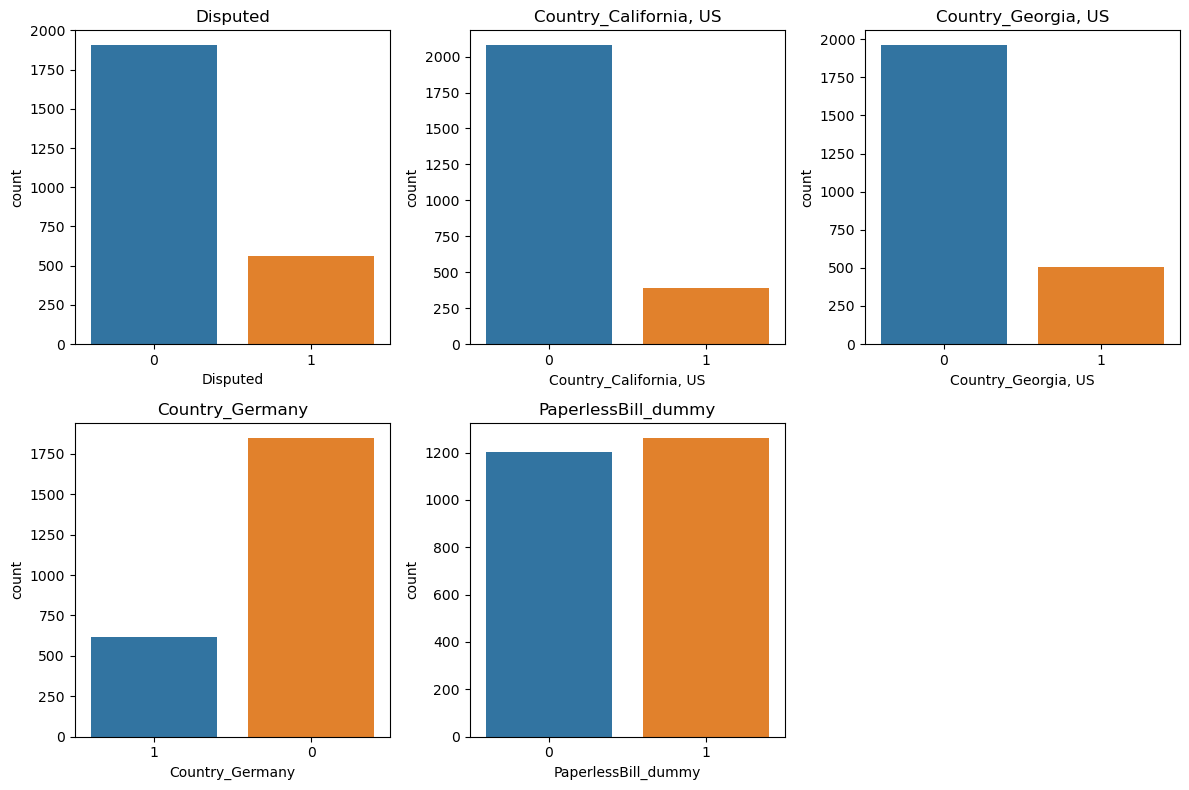

In [21]:
# Gráficos de barras para variáveis categóricas
plt.figure(figsize=(12, 8))

# Gráfico de barras para Disputed
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='Disputed')
plt.title('Disputed')

# Gráfico de barras para Country_California, US
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Country_California, US')
plt.title('Country_California, US')

# Gráfico de barras para Country_Georgia, US
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='Country_Georgia, US')
plt.title('Country_Georgia, US')

# Gráfico de barras para Country_Germany
plt.subplot(2, 3, 4)
sns.countplot(data=df, x='Country_Germany')
plt.title('Country_Germany')

# Gráfico de barras para PaperlessBill_dummy
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='PaperlessBill_dummy')
plt.title('PaperlessBill_dummy')

plt.tight_layout()
plt.show()

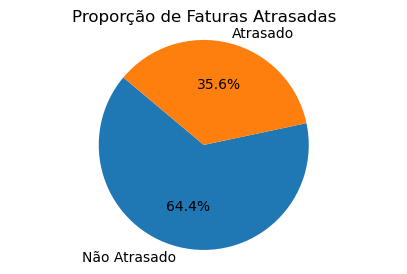

In [23]:
# Contagem faturas atrasadas
late_counts = df['IsLate'].value_counts()

# Plotar gráfico de pizza
plt.figure(figsize=(5, 3))
plt.pie(late_counts, labels=['Não Atrasado', 'Atrasado'], autopct='%1.1f%%', startangle=140)
plt.title('Proporção de Faturas Atrasadas')
plt.axis('equal')  # Garantir que o gráfico seja circular
plt.show()

In [24]:
#listar variáveis de data
datetime_vars = list(df.select_dtypes(include=['datetime']))
datetime_vars

['PaperlessDate', 'InvoiceDate', 'DueDate', 'SettledDate']

In [25]:
# Transformar variáveis datetime em ano, mês, dia e dia da semana

def datetime_transformation(col):
    for col in datetime_vars:
        df[col + '_year'] = df[col].dt.year
        df[col + '_month'] = df[col].dt.month
        df[col + '_day'] = df[col].dt.day
        df[col + '_weekDay'] = df[col].dt.weekday
        df.drop([col], axis=1, inplace=True)

datetime_transformation(datetime_vars)


### Correlation Analysis

Colunas que serão excluídas devido à alta correlação: ['SettledDate_year']


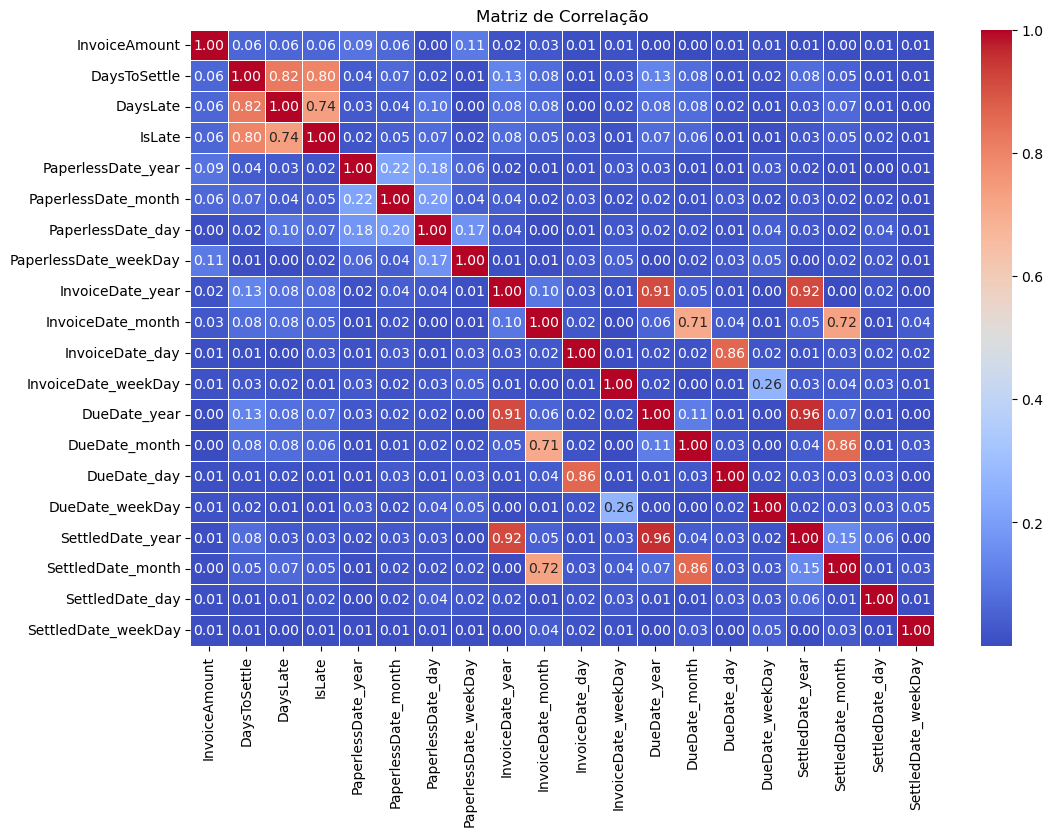

In [26]:
numeric_df = df.select_dtypes(include='number')

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr().abs()

# Criar uma máscara para selecionar apenas a metade superior da matriz de correlação
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encontrar índices de colunas com correlação maior que um limite
threshold = 0.95 # definindo um limite de correlação
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Print das colunas antes do drop
print(f"Colunas que serão excluídas devido à alta correlação: {to_drop}")


# Drop das colunas correlacionadas
df.drop(to_drop, axis=1, inplace=True)

# Plotar a matriz de correlação como um heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2466 entries, 611365 to 9990243864
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerID              2466 non-null   object 
 1   InvoiceAmount           2466 non-null   float64
 2   Disputed                2466 non-null   object 
 3   DaysToSettle            2466 non-null   int64  
 4   DaysLate                2466 non-null   int64  
 5   Country_California, US  2466 non-null   object 
 6   Country_Georgia, US     2466 non-null   object 
 7   Country_Germany         2466 non-null   object 
 8   Country_Kansas, US      2466 non-null   object 
 9   PaperlessBill_dummy     2466 non-null   object 
 10  IsLate                  2466 non-null   int32  
 11  PaperlessDate_year      2466 non-null   int32  
 12  PaperlessDate_month     2466 non-null   int32  
 13  PaperlessDate_day       2466 non-null   int32  
 14  PaperlessDate_weekDay   2466 non-n

## Modelling

In [28]:
#Selecionar Features
X = df.drop(columns =['DaysLate', 'customerID'], axis = 1)

#Selecionar Target 
y = df['DaysLate']

# Set Training e Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)

In [29]:
X.columns

Index(['InvoiceAmount', 'Disputed', 'DaysToSettle', 'Country_California, US',
       'Country_Georgia, US', 'Country_Germany', 'Country_Kansas, US',
       'PaperlessBill_dummy', 'IsLate', 'PaperlessDate_year',
       'PaperlessDate_month', 'PaperlessDate_day', 'PaperlessDate_weekDay',
       'InvoiceDate_year', 'InvoiceDate_month', 'InvoiceDate_day',
       'InvoiceDate_weekDay', 'DueDate_year', 'DueDate_month', 'DueDate_day',
       'DueDate_weekDay', 'SettledDate_month', 'SettledDate_day',
       'SettledDate_weekDay'],
      dtype='object')

In [30]:
#standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled, columns = ['InvoiceAmount', 'Disputed', 'DaysToSettle', 'Country_California, US',
       'Country_Georgia, US', 'Country_Germany', 'Country_Kansas, US',
       'PaperlessBill_dummy', 'IsLate', 'PaperlessDate_year',
       'PaperlessDate_month', 'PaperlessDate_day', 'PaperlessDate_weekDay',
       'InvoiceDate_year', 'InvoiceDate_month', 'InvoiceDate_day',
       'InvoiceDate_weekDay', 'DueDate_year', 'DueDate_month', 'DueDate_day',
       'DueDate_weekDay', 'SettledDate_month', 'SettledDate_day',
       'SettledDate_weekDay'])
df_scaled

,InvoiceAmount,Disputed,DaysToSettle,"Country_California, US","Country_Georgia, US",Country_Germany,"Country_Kansas, US",PaperlessBill_dummy,IsLate,PaperlessDate_year,...,InvoiceDate_month,InvoiceDate_day,InvoiceDate_weekDay,DueDate_year,DueDate_month,DueDate_day,DueDate_weekDay,SettledDate_month,SettledDate_day,SettledDate_weekDay
0,-0.193614,-0.542668,-1.090203,-0.431448,-0.508098,1.732988,-0.437384,0.975958,-0.742913,1.032147,...,-1.609594,-1.558808,-0.512167,0.936394,-1.434548,-1.683659,0.512509,-1.716396,-0.065287,-0.969251
1,0.090259,1.842748,0.774799,-0.431448,-0.508098,-0.577038,-0.437384,-1.024634,1.346053,-0.968855,...,-1.609594,1.130572,0.990216,0.936394,-1.434548,1.014937,-1.473110,-1.112123,-1.423928,1.527795
2,0.292885,-0.542668,-1.738899,-0.431448,-0.508098,1.732988,-0.437384,-1.024634,-0.742913,-0.968855,...,0.196804,-1.446750,-0.512167,0.936394,0.369734,-1.571217,0.512509,0.096424,-0.857828,-1.468660
3,2.252586,-0.542668,0.693712,-0.431448,-0.508098,-0.577038,-0.437384,-1.024634,1.346053,-0.968855,...,-1.308528,-0.662348,1.491011,0.936394,-1.133835,-0.446802,-0.976705,-1.112123,0.161153,1.527795
4,0.605635,1.842748,0.612625,2.317778,-0.508098,-0.577038,-0.437384,0.975958,1.346053,-0.968855,...,1.100003,1.018514,-0.011372,-1.050825,1.271875,0.902496,1.008913,1.304971,1.406573,-0.469841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,0.964881,-0.542668,1.423495,-0.431448,-0.508098,1.732988,-0.437384,-1.024634,1.346053,-0.968855,...,1.100003,0.234112,0.489422,0.936394,1.271875,0.115405,1.505318,1.607107,-1.650368,1.527795
2462,-1.059425,-0.542668,-0.198246,-0.431448,-0.508098,1.732988,-0.437384,0.975958,-0.742913,1.032147,...,0.798937,0.346169,-0.512167,-1.050825,0.971161,0.340288,0.512509,1.002834,-0.291728,1.028386
2463,0.376579,-0.542668,-0.117159,-0.431448,1.968125,-0.577038,-0.437384,0.975958,-0.742913,-0.968855,...,0.196804,-1.558808,-1.513756,-1.050825,0.369734,-1.683659,-0.480301,0.096424,1.293353,0.528977
2464,-0.329677,-0.542668,-0.441507,-0.431448,1.968125,-0.577038,-0.437384,0.975958,-0.742913,-0.968855,...,-0.706395,1.242629,0.489422,-1.050825,-0.532407,1.239820,1.505318,-0.507849,0.274373,0.528977


In [31]:
# Scale trainint data
X_train = scaler.fit_transform(X_train)

# Scale test data
X_test = scaler.fit_transform(X_test)

##### Regressão Linear

In [32]:
# Inicializar modelo de regressão linear
model = LinearRegression()

# Fit trainint data
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
mse=mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(mse)

print('Mean squared error:', mse)
print('RMSE:', RMSE)
print('R2 score:', r2_score(y_test, y_pred))

Mean squared error: 11.195198095990174
RMSE: 3.3459226075912416
R2 score: 0.6873409485439081


##### Ridge e Lasso Regression

In [33]:
# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)

#standardization
scaler = StandardScaler()

# Scale trainint data
X_train = scaler.fit_transform(X_train)

# Scale test data
X_test = scaler.fit_transform(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=0.05)  # Alpha é o parâmetro de regularização
ridge_model.fit(X_train, y_train)

# Previsões
y_pre_ridge = ridge_model.predict(X_test)

# Avaliação do modelo
ridge_mse = mean_squared_error(y_test, y_pre_ridge)
print("Erro Quadrático Médio (Ridge):", ridge_mse)
print('Mean squared error (Ridge):', np.sqrt(ridge_mse))
print('R2 score (Ridge):', r2_score(y_test, y_pre_ridge))

# Lasso Regression
lasso_model = Lasso(alpha=0.05)  # Alpha é o parâmetro de regularização
lasso_model.fit(X_train, y_train)

# Previsões
y_pred_lasso = lasso_model.predict(X_test)

# Avaliação do modelo
print('------------------------')
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print('Mean absolute error:', lasso_mse)
print('Mean squared error:', np.sqrt(lasso_mse))
print('R2 score:', r2_score(y_test, y_pred_lasso))

Erro Quadrático Médio (Ridge): 11.577365657249253
Mean squared error (Ridge): 3.402552814762653
R2 score (Ridge): 0.7292278770298748
------------------------
Mean absolute error: 11.686386528082753
Mean squared error: 3.4185357286538274
R2 score: 0.7266780903584005


##### Árvore de Decisão

In [34]:
# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)

#standardization
scaler = StandardScaler()

# Scale trainint data
X_train = scaler.fit_transform(X_train)

# Scale test data
X_test = scaler.fit_transform(X_test)

# Decision Tree Regression
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Previsões
y_pred = tree_model.predict(X_test)

# Avaliação do modelo
tree_mse = mean_squared_error(y_test, y_pred)
print("Erro Quadrático Médio (decision_tree):", tree_mse)
print('Mean squared error (decision_tree):', np.sqrt(tree_mse))
print('R2 score (decision_tree):', r2_score(y_test, y_pred))

Erro Quadrático Médio (decision_tree): 0.9825785698377711
Mean squared error (decision_tree): 0.9912510125279929
R2 score (decision_tree): 0.9689102382968701


##### Random Forest

In [36]:
# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)

# Standardization
scaler = StandardScaler()

# Scale trainint data
X_train = scaler.fit_transform(X_train)

# Scale test data
X_test = scaler.fit_transform(X_test)

forest_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
forest_model.fit(X_train, y_train)

# Previsões
y_pred_forest = forest_model.predict(X_test)

# Avaliação do modelo
forest_mse = mean_squared_error(y_test, y_pred)
print("Erro Quadrático Médio (forest):", forest_mse)
print('Mean squared error (forest):', np.sqrt(forest_mse))
print('R2 score (forest):', r2_score(y_test, y_pred_forest))

Erro Quadrático Médio (forest): 77.97349855345725
Mean squared error (forest): 8.830260389901152
R2 score (forest): 0.9936141750315411


##### Gradient Boosting sem hyperparâmetros otimizados

In [37]:
# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)

#standardization
scaler = StandardScaler()

# Scale trainint data
X_train = scaler.fit_transform(X_train)

# Scale test data
X_test = scaler.fit_transform(X_test)
gb_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Previsões
y_pred_gb = gb_model.predict(X_test)

# Avaliação do modelo
gb_mse = mean_squared_error(y_test, y_pred_gb)
print("Erro Quadrático Médio (gb):", gb_mse)
print('Mean squared error (gb):', np.sqrt(gb_mse))
print('R2 score (gb):', r2_score(y_test, y_pred_gb))

Erro Quadrático Médio (gb): 1.8087857080266487e-16
Mean squared error (gb): 1.344911040934176e-08
R2 score (gb): 1.0


##### Otimização

In [38]:
# Definir distribuição dos hiperparâmetros
param_dist = {
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.5, 0.5),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Criação do estimador
gb = GradientBoostingRegressor()

# Criar objeto de random search
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=2, random_state=42)

# Correr random search
random_search.fit(X_train, y_train)

# Analisar os resultados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print("Melhor MSE encontrado:")
print(-random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.19727005942368125, max_depth=7, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=800, subsample=0.7984250789732434; total time=   2.5s
[CV] END learning_rate=0.19727005942368125, max_depth=7, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=800, subsample=0.7984250789732434; total time=   2.4s
[CV] END learning_rate=0.19727005942368125, max_depth=7, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=800, subsample=0.7984250789732434; total time=   2.4s
[CV] END learning_rate=0.19727005942368125, max_depth=7, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=800, subsample=0.7984250789732434; total time=   2.1s
[CV] END learning_rate=0.19727005942368125, max_depth=7, max_features=log2, min_samples_leaf=11, min_samples_split=9, n_estimators=800, subsample=0.7984250789732434; total time=   1.7s
[CV] END lea

[CV] END learning_rate=0.09668232675388604, max_depth=3, max_features=None, min_samples_leaf=18, min_samples_split=9, n_estimators=487, subsample=0.6558555380447055; total time=   1.4s
[CV] END learning_rate=0.2700340105889054, max_depth=4, max_features=None, min_samples_leaf=18, min_samples_split=13, n_estimators=261, subsample=0.6975751180009072; total time=   1.0s
[CV] END learning_rate=0.2700340105889054, max_depth=4, max_features=None, min_samples_leaf=18, min_samples_split=13, n_estimators=261, subsample=0.6975751180009072; total time=   1.0s
[CV] END learning_rate=0.2700340105889054, max_depth=4, max_features=None, min_samples_leaf=18, min_samples_split=13, n_estimators=261, subsample=0.6975751180009072; total time=   1.0s
[CV] END learning_rate=0.2700340105889054, max_depth=4, max_features=None, min_samples_leaf=18, min_samples_split=13, n_estimators=261, subsample=0.6975751180009072; total time=   1.0s
[CV] END learning_rate=0.2700340105889054, max_depth=4, max_features=None, 

[CV] END learning_rate=0.4536063712881633, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=16, n_estimators=561, subsample=0.9244569121330419; total time=   0.6s
[CV] END learning_rate=0.3708647605824366, max_depth=9, max_features=log2, min_samples_leaf=14, min_samples_split=8, n_estimators=894, subsample=0.7613664146909971; total time=   1.9s
[CV] END learning_rate=0.3708647605824366, max_depth=9, max_features=log2, min_samples_leaf=14, min_samples_split=8, n_estimators=894, subsample=0.7613664146909971; total time=   1.9s
[CV] END learning_rate=0.3708647605824366, max_depth=9, max_features=log2, min_samples_leaf=14, min_samples_split=8, n_estimators=894, subsample=0.7613664146909971; total time=   1.9s
[CV] END learning_rate=0.3708647605824366, max_depth=9, max_features=log2, min_samples_leaf=14, min_samples_split=8, n_estimators=894, subsample=0.7613664146909971; total time=   2.0s
[CV] END learning_rate=0.3708647605824366, max_depth=9, max_features=log2, min_s

[CV] END learning_rate=0.09414552108646528, max_depth=3, max_features=None, min_samples_leaf=17, min_samples_split=18, n_estimators=541, subsample=0.9812236474710556; total time=   2.1s
[CV] END learning_rate=0.1358911479126821, max_depth=4, max_features=log2, min_samples_leaf=17, min_samples_split=6, n_estimators=724, subsample=0.9988702425244709; total time=   1.0s
[CV] END learning_rate=0.1358911479126821, max_depth=4, max_features=log2, min_samples_leaf=17, min_samples_split=6, n_estimators=724, subsample=0.9988702425244709; total time=   1.0s
[CV] END learning_rate=0.1358911479126821, max_depth=4, max_features=log2, min_samples_leaf=17, min_samples_split=6, n_estimators=724, subsample=0.9988702425244709; total time=   1.0s
[CV] END learning_rate=0.1358911479126821, max_depth=4, max_features=log2, min_samples_leaf=17, min_samples_split=6, n_estimators=724, subsample=0.9988702425244709; total time=   1.0s
[CV] END learning_rate=0.1358911479126821, max_depth=4, max_features=log2, min

[CV] END learning_rate=0.4186111001006079, max_depth=3, max_features=None, min_samples_leaf=17, min_samples_split=3, n_estimators=996, subsample=0.5465513839029497; total time=   2.8s
[CV] END learning_rate=0.4586078789766634, max_depth=7, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=198, subsample=0.8501789149863856; total time=   1.5s
[CV] END learning_rate=0.4586078789766634, max_depth=7, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=198, subsample=0.8501789149863856; total time=   1.5s
[CV] END learning_rate=0.4586078789766634, max_depth=7, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=198, subsample=0.8501789149863856; total time=   1.5s
[CV] END learning_rate=0.4586078789766634, max_depth=7, max_features=None, min_samples_leaf=9, min_samples_split=10, n_estimators=198, subsample=0.8501789149863856; total time=   1.5s
[CV] END learning_rate=0.4586078789766634, max_depth=7, max_features=None, min_s

[CV] END learning_rate=0.03180188587721688, max_depth=6, max_features=None, min_samples_leaf=14, min_samples_split=7, n_estimators=198, subsample=0.873859386948707; total time=   1.0s
[CV] END learning_rate=0.03180188587721688, max_depth=6, max_features=None, min_samples_leaf=14, min_samples_split=7, n_estimators=198, subsample=0.873859386948707; total time=   1.1s
[CV] END learning_rate=0.03180188587721688, max_depth=6, max_features=None, min_samples_leaf=14, min_samples_split=7, n_estimators=198, subsample=0.873859386948707; total time=   1.1s
[CV] END learning_rate=0.03180188587721688, max_depth=6, max_features=None, min_samples_leaf=14, min_samples_split=7, n_estimators=198, subsample=0.873859386948707; total time=   1.1s
[CV] END learning_rate=0.03180188587721688, max_depth=6, max_features=None, min_samples_leaf=14, min_samples_split=7, n_estimators=198, subsample=0.873859386948707; total time=   1.1s
[CV] END learning_rate=0.4865359235119766, max_depth=7, max_features=auto, min_s

[CV] END learning_rate=0.16163275733661142, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=363, subsample=0.8849967765493054; total time=   2.1s
[CV] END learning_rate=0.16163275733661142, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=363, subsample=0.8849967765493054; total time=   2.2s
[CV] END learning_rate=0.16163275733661142, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=363, subsample=0.8849967765493054; total time=   2.2s
[CV] END learning_rate=0.16163275733661142, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=363, subsample=0.8849967765493054; total time=   2.2s
[CV] END learning_rate=0.16163275733661142, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=2, n_estimators=363, subsample=0.8849967765493054; total time=   2.2s
[CV] END learning_rate=0.11791051374842158, max_depth=7, max_features=log2, min_

[CV] END learning_rate=0.03265200488602226, max_depth=9, max_features=sqrt, min_samples_leaf=19, min_samples_split=2, n_estimators=424, subsample=0.8419818846990705; total time=   0.9s
[CV] END learning_rate=0.03265200488602226, max_depth=9, max_features=sqrt, min_samples_leaf=19, min_samples_split=2, n_estimators=424, subsample=0.8419818846990705; total time=   0.9s
[CV] END learning_rate=0.03265200488602226, max_depth=9, max_features=sqrt, min_samples_leaf=19, min_samples_split=2, n_estimators=424, subsample=0.8419818846990705; total time=   0.9s
[CV] END learning_rate=0.03265200488602226, max_depth=9, max_features=sqrt, min_samples_leaf=19, min_samples_split=2, n_estimators=424, subsample=0.8419818846990705; total time=   0.8s
[CV] END learning_rate=0.03265200488602226, max_depth=9, max_features=sqrt, min_samples_leaf=19, min_samples_split=2, n_estimators=424, subsample=0.8419818846990705; total time=   0.9s
[CV] END learning_rate=0.3179255821949569, max_depth=9, max_features=sqrt, 

[CV] END learning_rate=0.20480904310960174, max_depth=7, max_features=log2, min_samples_leaf=19, min_samples_split=18, n_estimators=711, subsample=0.5054188257401492; total time=   1.0s
[CV] END learning_rate=0.20480904310960174, max_depth=7, max_features=log2, min_samples_leaf=19, min_samples_split=18, n_estimators=711, subsample=0.5054188257401492; total time=   1.0s
[CV] END learning_rate=0.20480904310960174, max_depth=7, max_features=log2, min_samples_leaf=19, min_samples_split=18, n_estimators=711, subsample=0.5054188257401492; total time=   1.1s
[CV] END learning_rate=0.20480904310960174, max_depth=7, max_features=log2, min_samples_leaf=19, min_samples_split=18, n_estimators=711, subsample=0.5054188257401492; total time=   1.1s
[CV] END learning_rate=0.20480904310960174, max_depth=7, max_features=log2, min_samples_leaf=19, min_samples_split=18, n_estimators=711, subsample=0.5054188257401492; total time=   1.0s
[CV] END learning_rate=0.46269098820963184, max_depth=6, max_features=

[CV] END learning_rate=0.18510912335015678, max_depth=6, max_features=log2, min_samples_leaf=19, min_samples_split=13, n_estimators=281, subsample=0.8525421821483299; total time=   0.4s
[CV] END learning_rate=0.18510912335015678, max_depth=6, max_features=log2, min_samples_leaf=19, min_samples_split=13, n_estimators=281, subsample=0.8525421821483299; total time=   0.5s
[CV] END learning_rate=0.18510912335015678, max_depth=6, max_features=log2, min_samples_leaf=19, min_samples_split=13, n_estimators=281, subsample=0.8525421821483299; total time=   0.4s
[CV] END learning_rate=0.18510912335015678, max_depth=6, max_features=log2, min_samples_leaf=19, min_samples_split=13, n_estimators=281, subsample=0.8525421821483299; total time=   0.4s
[CV] END learning_rate=0.18510912335015678, max_depth=6, max_features=log2, min_samples_leaf=19, min_samples_split=13, n_estimators=281, subsample=0.8525421821483299; total time=   0.4s
[CV] END learning_rate=0.13436207721514398, max_depth=5, max_features=

[CV] END learning_rate=0.31670759796789494, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=14, n_estimators=104, subsample=0.5131834872486261; total time=   0.0s
[CV] END learning_rate=0.31670759796789494, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=14, n_estimators=104, subsample=0.5131834872486261; total time=   0.0s
[CV] END learning_rate=0.31670759796789494, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=14, n_estimators=104, subsample=0.5131834872486261; total time=   0.0s
[CV] END learning_rate=0.31670759796789494, max_depth=4, max_features=sqrt, min_samples_leaf=18, min_samples_split=14, n_estimators=104, subsample=0.5131834872486261; total time=   0.0s
[CV] END learning_rate=0.1982316834390248, max_depth=3, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=878, subsample=0.7970653576760676; total time=   1.0s
[CV] END learning_rate=0.1982316834390248, max_depth=3, max_features=sq

C:\Users\ricky\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
125 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricky\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricky\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ricky\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ricky\anaconda3\Lib\site-packag

Melhores hiperparâmetros encontrados:
{'learning_rate': 0.3359806297513003, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 900, 'subsample': 0.7469468575917173}
Melhor MSE encontrado:
0.043986295517676445


##### Gradient Boosting com hyperparâmetros otimizados

In [39]:
# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2)

#standardization
scaler = StandardScaler()

# Scale trainint data
X_train = scaler.fit_transform(X_train)

# Scale test data
X_test = scaler.fit_transform(X_test)
gb_model = GradientBoostingRegressor(learning_rate=0.3359806297513003, max_depth=3, 
                                     max_features=None, min_samples_leaf=1, min_samples_split=5, 
                                     n_estimators=900, subsample=0.746946857591717)
gb_model.fit(X_train, y_train)

# Previsões
y_pred = gb_model.predict(X_test)

gb_mse = mean_squared_error(y_test, y_pred)
print("Erro Quadrático Médio (gb):", gb_mse)
print('Mean squared error (gb):', np.sqrt(gb_mse))
print('R2 score (gb):', r2_score(y_test, y_pred))

Erro Quadrático Médio (gb): 0.09472949142169307
Mean squared error (gb): 0.3077815644604028
R2 score (gb): 0.9973637487128206
